In [1]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#!pip install psycopg2-binary

In [3]:
import psycopg2 as pg

# Call DB

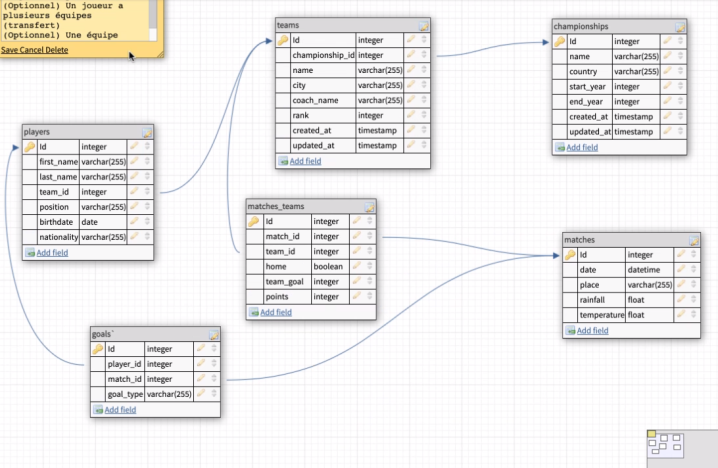

In [4]:
#Connexion
#conn = sqlite3.connect('data.sqlite')
conn = pg.connect(dbname='d18d5k6eqpagnc',
                  user='qshqwgcxyldiib',
                  host='ec2-54-74-14-109.eu-west-1.compute.amazonaws.com',
                  password = '726d500b6531d0c8fb04410eb021d11ccccb5f369efa9cb7045538a1f56a8faa')
cursor = conn.cursor()

In [5]:
def view_table(table):
    df_db = pd.read_sql_query(f"""
    SELECT *
    FROM {table}
    ;""", conn)
    display(df_db.head(3))
    display(df_db.shape)

In [6]:
view_table('matches')

,id,date,place,rainfall,temperature
0,1,,Bordeaux,5.0,22.5
1,2,,Dijon,19.0,22.0
2,3,,Lille,1.0,19.0


(380, 5)

In [7]:
view_table('matches_teams')

,id,match_id,team_id,home,team_goal,points
0,1,1,2,1,0,1
1,2,1,13,0,0,1
2,3,2,4,1,0,0


(760, 6)

# Evolution du nombre de buts d’une équipe en fonction de la météo (pluviométrie, température)

In [8]:
#create DF
data = pd.read_sql(f"""
SELECT t.city, mt.team_goal, m.temperature, m.rainfall
FROM matches_teams AS mt
JOIN matches as m
ON m.id = mt.match_id
JOIN teams as t
ON mt.team_id = t.id
;""", conn)

# Evolution du nombre de buts d’un joueur en fonction de la météo (pluviométrie, température)

In [9]:
#create DF
data2 = pd.read_sql(f"""
SELECT g.match_id, p.last_name, t.city, m.temperature, m.rainfall
FROM goals AS g
JOIN players as p
ON p.id = g.player_id
JOIN matches as m
ON g.match_id = m.id
join teams as t
ON p.team_id = t.id
;""", conn)
data2

,match_id,last_name,city,temperature,rainfall
0,2,I. Traoré,Angers,22.0,19.0
1,3,J. Bamba,Lille,19.0,1.0
2,3,D. Da Silva,Rennes,19.0,1.0
3,4,A. Disasi,Monaco,25.5,1.0
4,4,B. Badiashile,Monaco,25.5,1.0
...,...,...,...,...,...
1044,379,E. Touré,Reims,10.5,1.0
1045,379,Y. Adli,Bordeaux,10.5,1.0
1046,379,E. Kwateng,Bordeaux,10.5,1.0
1047,380,H. Diallo,Strasbourg,12.0,2.0


In [10]:
data2['buts'] = 1

In [11]:
df_total_but = data2[['city','temperature','rainfall', 'buts']].groupby(data2['match_id']).sum()
df_total_but

,temperature,rainfall,buts
match_id,,,
2,22.0,19.0,1
3,38.0,2.0,2
4,102.0,4.0,4
5,68.0,4.0,4
6,106.0,0.0,4
...,...,...,...
376,20.0,4.0,2
377,36.0,3.0,3
378,12.0,0.0,1


In [12]:
df_score_player_match = pd.DataFrame()
#data2[['city','temperature','rainfall', 'buts']].groupby(data2['last_name']).sum()

for i in range(data2['match_id'].min(), data2['match_id'].max()+1):
    
    new_df = pd.DataFrame(data2['buts'][data2['match_id'] == i].groupby(
        data2['last_name']).sum()).reset_index().assign(
        temperature=data2['temperature'][data2['match_id'] == i].mean()).assign(
        rainfall=data2['rainfall'][data2['match_id'] == i].mean()).assign(
        match_id=i)
    
    df_score_player_match = df_score_player_match.append(new_df, ignore_index=True)


In [13]:
df_score_player_match['buts'].groupby(df_score_player_match['last_name']).sum().sort_values(ascending = False)

last_name
K. Mbappé        27
W. Ben Yedder    20
M. Depay         20
K. Volland       16
L. Ajorque       16
                 ..
I. Sylla          1
N. Sissoko        1
J. Amavi          1
J. Bellegarde     1
Z. Youssouf       1
Name: buts, Length: 287, dtype: int64

In [14]:
df_score_player_match[df_score_player_match['last_name'] == 'K. Mbappé']

,last_name,buts,temperature,rainfall,match_id
72,K. Mbappé,1,23.0,16.0,34
121,K. Mbappé,1,13.5,31.0,51
147,K. Mbappé,2,12.5,0.0,62
181,K. Mbappé,2,14.5,1.0,73
204,K. Mbappé,1,14.0,0.0,82
252,K. Mbappé,2,14.5,3.0,102
309,K. Mbappé,1,8.0,0.0,123
367,K. Mbappé,1,8.5,0.0,147
427,K. Mbappé,1,12.5,18.0,168
508,K. Mbappé,2,6.0,12.0,201


In [15]:
def team_bar_meteo(team):

    """Function team_bar_meteo(team) plots number of goals by temperature and rainfall for a team
    Parameters: team - data frame
    Return: None
    """
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.barplot(data=data[data['city'] == team], x='temperature', y='team_goal', ax=ax[0])
    sns.barplot(data=data[data['city'] == team], x='rainfall', y='team_goal', ax=ax[1])
    plt.suptitle(f'Distributions des buts de {team}', fontsize = 30, fontweight = 'bold')
    ax[0].set_title(f"Nb de buts en fonction de la temperature", fontsize = 14, fontweight = 'bold')
    ax[1].set_title(f"Nb de buts en fonction de la pluviométrie", fontsize = 14, fontweight = 'bold')
    plt.show()
    return
    
def player_bar_meteo(player):

    """Function player_bar_meteo(player) plots number of goals by temperature and rainfall for a player
    Parameters: player - data frame
    Return: None
    """
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.barplot(data=df_score_player_match[df_score_player_match['last_name'] == player], x='temperature', y='buts', ax=ax[0])
    sns.barplot(data=df_score_player_match[df_score_player_match['last_name'] == player], x='rainfall', y='buts', ax=ax[1])
    plt.suptitle(f'Distributions des buts de {player}', fontsize = 30, fontweight = 'bold')
    ax[0].set_title(f"Nb de buts en fonction de la temperature", fontsize = 14, fontweight = 'bold')
    ax[1].set_title(f"Nb de buts en fonction de la pluviométrie", fontsize = 14, fontweight = 'bold')
    plt.show()
    return

In [16]:
interact(team_bar_meteo, team=data['city'].unique())

interactive(children=(Dropdown(description='team', options=('Bordeaux', 'Nantes', 'Dijon', 'Angers', 'Lille', …

<function __main__.team_bar_meteo(team)>

In [17]:
interact(player_bar_meteo, player=data2['last_name'].unique())

interactive(children=(Dropdown(description='player', options=('I. Traoré', 'J. Bamba', 'D. Da Silva', 'A. Disa…

<function __main__.player_bar_meteo(player)>

In [18]:
df3['last_name'][df3['buts'] == 1].value_counts()

NameError: name 'df3' is not defined

In [24]:
data2['buts'][data2['last_name'] == 'M. Depay'].sum()

20

In [25]:
df3['buts'][df3['last_name'] == 'M. Depay'].sum()

NameError: name 'df3' is not defined

# Evolution du nombre de buts total en fonction de la météo

In [26]:
player_meteo = data2.copy()
player_meteo = player_meteo.rename(columns = {"match_id": "id"})
player_meteo = player_meteo.drop(['buts'], axis = 1)
player_meteo["player-club"] = player_meteo.last_name + ': ' + player_meteo.city
player_meteo["is_rain"] = [True if mm>1 else False for mm in player_meteo['rainfall']]

In [27]:
player_meteo

,id,last_name,city,temperature,rainfall,player-club,is_rain
0,2,I. Traoré,Angers,22.0,19.0,I. Traoré: Angers,True
1,3,J. Bamba,Lille,19.0,1.0,J. Bamba: Lille,False
2,3,D. Da Silva,Rennes,19.0,1.0,D. Da Silva: Rennes,False
3,4,A. Disasi,Monaco,25.5,1.0,A. Disasi: Monaco,False
4,4,B. Badiashile,Monaco,25.5,1.0,B. Badiashile: Monaco,False
...,...,...,...,...,...,...,...
1044,379,E. Touré,Reims,10.5,1.0,E. Touré: Reims,False
1045,379,Y. Adli,Bordeaux,10.5,1.0,Y. Adli: Bordeaux,False
1046,379,E. Kwateng,Bordeaux,10.5,1.0,E. Kwateng: Bordeaux,False
1047,380,H. Diallo,Strasbourg,12.0,2.0,H. Diallo: Strasbourg,True


In [28]:
def plot_player_goals_meteo(player):
    df = player_meteo[player_meteo['player-club']==player]
    sns.scatterplot(data = df, 
                    x = 'rainfall', 
                    y= 'temperature',  
                    alpha = 0.9)

In [29]:
number_goals_by_player = player_meteo[['player-club', 'temperature']].groupby(by='player-club', as_index=False).count()
number_goals_by_player = number_goals_by_player.sort_values(by= 'temperature', ascending = False)
players_list = number_goals_by_player['player-club'].values

In [30]:
w = interactive(plot_player_goals_meteo, player = 
                        widgets.Dropdown(
                        options=players_list,
                        value=players_list[0], 
                        layout={'width': 'max-content'},
                        description='Model:',)  )
display(w)

interactive(children=(Dropdown(description='Model:', layout=Layout(width='max-content'), options=('K. Mbappé: …

Text(0.5, 1.0, 'Total nombre de buts par temperature')

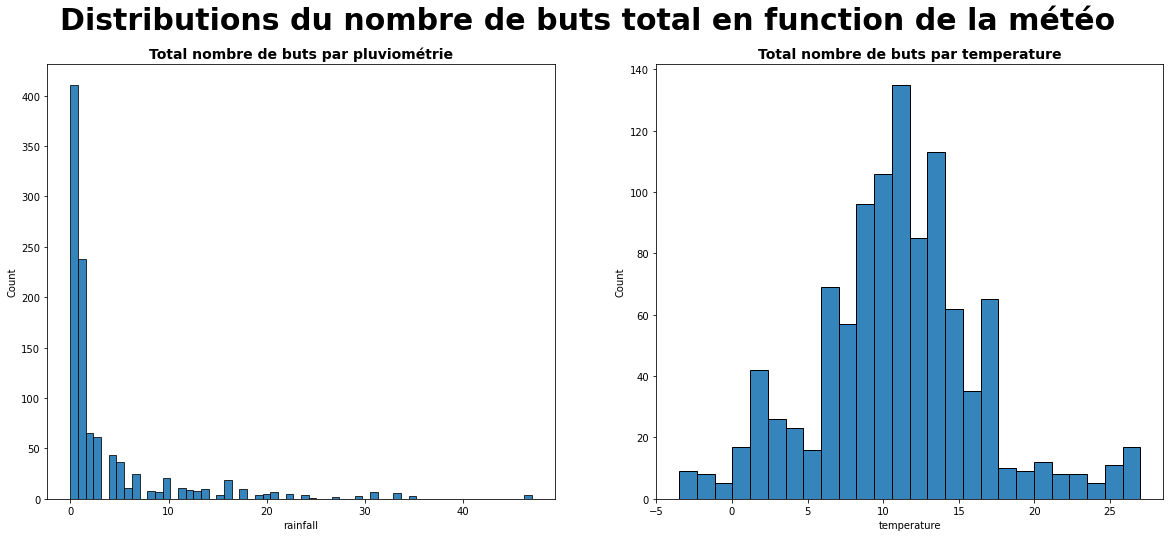

In [31]:
# total numbre de buts par pluvoimetrie
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data = player_meteo, 
                x = 'rainfall',  
                alpha = 0.9, ax = ax[0])
# totlal numbre de buts par temperature
sns.histplot(data = player_meteo, 
                x = 'temperature',  
                alpha = 0.9,
            ax = ax[1])

plt.suptitle(f'Distributions du nombre de buts total en function de la météo', fontsize = 30, fontweight = 'bold')

ax[0].set_title(f"Total nombre de buts par pluviométrie",
                fontsize=14,
                fontweight='bold')
ax[1].set_title(f"Total nombre de buts par temperature",
                fontsize=14,
                fontweight='bold')

In [32]:
#assuption is_rain = true si le plue > 1mm et faux si non
match_meteo = pd.read_sql_query(f"""
    SELECT *
    FROM matches
    ;""", conn)

match_meteo["is_rain"] = [True if mm>1 else False for mm in match_meteo['rainfall']]
match_meteo

,id,date,place,rainfall,temperature,is_rain
0,1,,Bordeaux,5.0,22.5,True
1,2,,Dijon,19.0,22.0,True
2,3,,Lille,1.0,19.0,False
3,4,,Monaco,1.0,25.5,False
4,5,,Lorient,1.0,17.0,False
...,...,...,...,...,...,...
375,376,,Rennes,2.0,10.0,True
376,377,,Nantes,1.0,12.0,False
377,378,,Saint-Étienne,0.0,12.0,False
378,379,,Reims,1.0,10.5,False


Text(0.5, 1.0, 'Total nombre de match par témpérature')

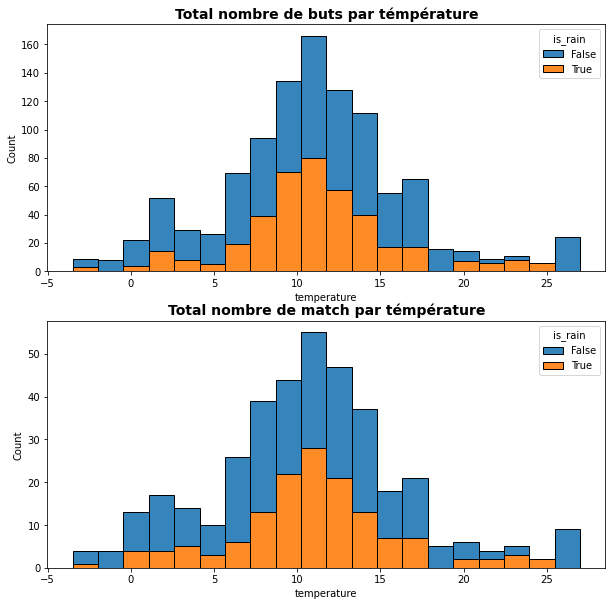

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.histplot(data=player_meteo,
             x='temperature',
             hue='is_rain',
             bins=20,
             multiple="stack",
             alpha=0.9,
             ax=ax[0])
sns.histplot(data=match_meteo,
             x='temperature',
             bins=20,
             hue='is_rain',
             multiple="stack",
             alpha=0.9,
             ax=ax[1])
ax[0].set_title(f"Total nombre de buts par témpérature",
                fontsize=14,
                fontweight='bold')
ax[1].set_title(f"Total nombre de match par témpérature",
                fontsize=14,
                fontweight='bold')

# Evolution du nombre de buts moyen par mathc en fonction de la temperature

In [34]:
df1 = player_meteo[['temperature', 'is_rain', 'id', 'last_name']].groupby(by = ['temperature', 'is_rain', 'id'], as_index= False).count()
df1 = df1.rename(columns = {"last_name": "number_goals_per_match"})

In [35]:
no_rain = df1[df1.is_rain == False]
rain = df1[df1.is_rain == True]

In [36]:
def regroup_by_temperature(df0, g='temperature'):
    """This function return data frame groupped by temperature
    Parameters: df0 - data frame
    Return: df - data frame.
    """
    df = df0[[g, 'number_goals_per_match']].groupby(by = g, as_index= False).sum()
    df = df.rename(columns = {"number_goals_per_match": "total_goals"})
    df['num_match'] = df0[[g, 'id']].groupby(by = g, as_index= False).count()["id"]
    df['mean_goals_per_match'] = df['total_goals']/df['num_match']
    return df

In [37]:
df_rain = regroup_by_temperature(rain)
df_no_rain = regroup_by_temperature(no_rain)
df_no_rain.head(3)

,temperature,total_goals,num_match,mean_goals_per_match
0,-3.0,2,1,2.000000
1,-2.5,4,2,2.000000
2,-1.5,8,3,2.666667


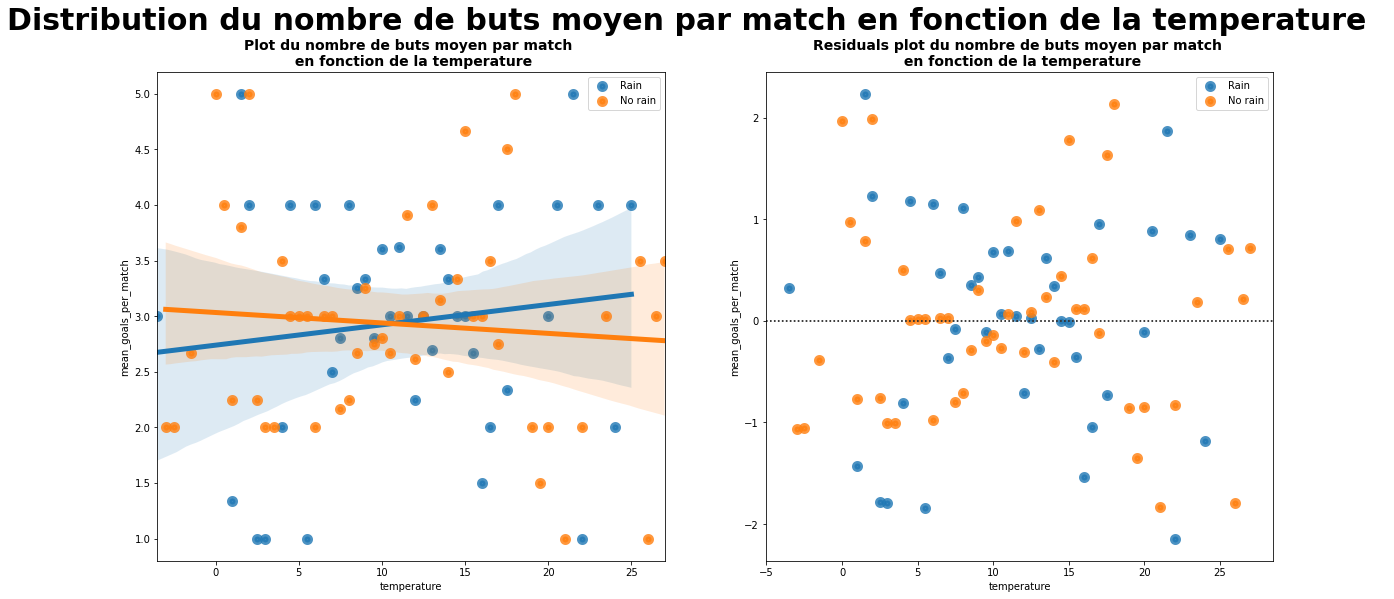

In [38]:
def plot_mean_goals_per_match_per_temperature(df_rain, df_no_rain, feature = 'temperature'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 9))

    sns.regplot(data=df_rain,
                x=feature,
                y='mean_goals_per_match',
                 scatter_kws = {'lw': 5},
                  line_kws = {'lw':5},
                label='Rain',
                ax=ax[0])
    sns.regplot(data=df_no_rain,
                x=feature,
                y='mean_goals_per_match',
                 scatter_kws = {'lw': 5},
                  line_kws = {'lw':5},
                label='No rain',
                ax=ax[0])


    sns.residplot(data=df_rain,
                  x=feature,
                  y='mean_goals_per_match',
                  scatter_kws = {'lw': 5},
                  line_kws = {'lw':5},
                  label='Rain',
                  ax=ax[1])
    sns.residplot(data=df_no_rain,
                  x=feature,
                  y='mean_goals_per_match',
                  label='No rain',
                  scatter_kws = {'lw': 5},
                  ax=ax[1])

    ax[0].legend()
    ax[0].set_title(f"Plot du nombre de buts moyen par match \n en fonction de la {feature}",
                    fontsize=14,
                    fontweight='bold')
    ax[1].legend()
    ax[1].set_title(f"Residuals plot du nombre de buts moyen par match \n en fonction de la {feature}",
                    fontsize=14,
                    fontweight='bold')
    plt.suptitle(f'Distribution du nombre de buts moyen par match en fonction de la {feature}  ', fontsize = 30, fontweight = 'bold')
    
plot_mean_goals_per_match_per_temperature(df_rain, df_no_rain)

In [39]:
temperature_bins = [-5., 5., 10., 15., 20., 30.]
temperature_labels = [0., 7.5, 12.5, 17.5, 25.]
no_rain2 = no_rain.copy()
rain2 = rain.copy()
no_rain2['cut_temperature'] = pd.cut(no_rain2['temperature'],
                                     bins=temperature_bins,
                                     labels=temperature_labels)
rain2['cut_temperature'] = pd.cut(rain2['temperature'],
                                  bins=temperature_bins,
                                  labels=temperature_labels)
rain2.tail()

,temperature,is_rain,id,number_goals_per_match,cut_temperature
340,22.0,True,2,1,25.0
341,23.0,True,34,3,25.0
342,23.0,True,35,5,25.0
344,24.0,True,40,2,25.0
345,25.0,True,22,4,25.0


In [40]:
df_no_rain2 = regroup_by_temperature(no_rain2, "cut_temperature")
df_rain2 = regroup_by_temperature(rain2, "cut_temperature")
df_rain2

,cut_temperature,total_goals,num_match,mean_goals_per_match
0,0.0,33,14,2.357143
1,7.5,129,40,3.225000
2,12.5,183,60,3.050000
3,17.5,31,12,2.583333
4,25.0,24,7,3.428571


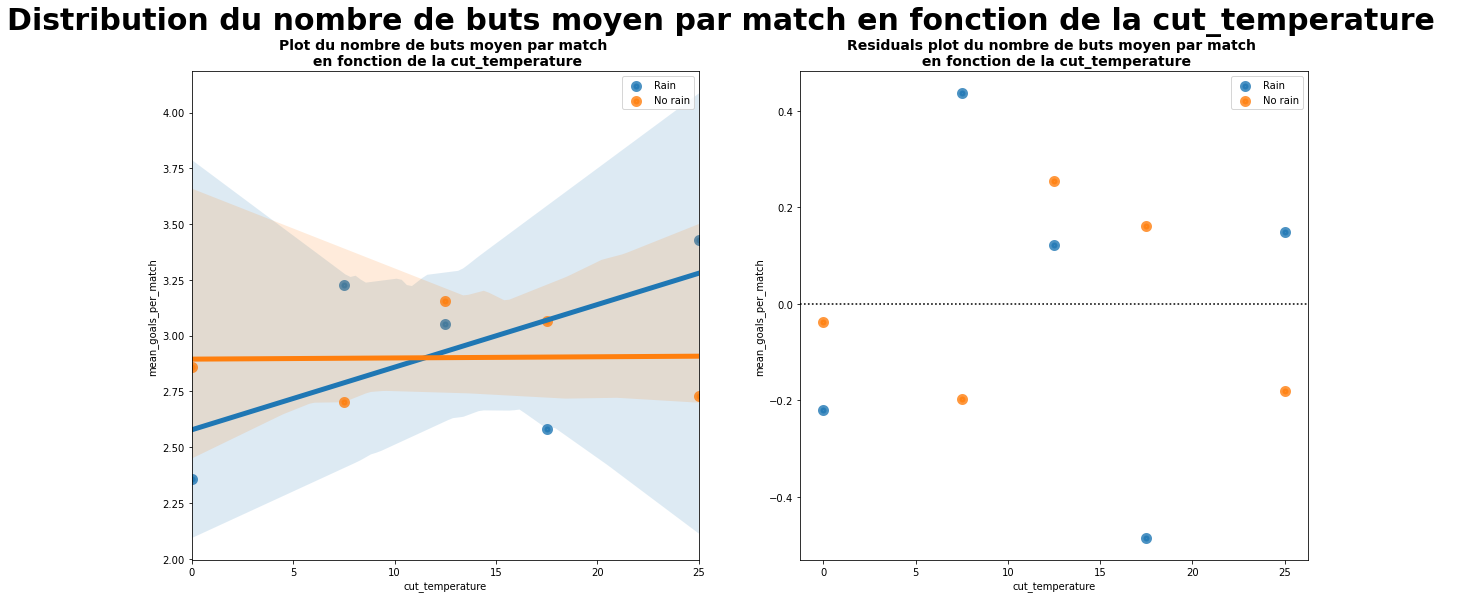

In [41]:
plot_mean_goals_per_match_per_temperature(df_rain2, df_no_rain2, 'cut_temperature')